In [1]:
# Scientific libraries
import numpy as np


%matplotlib notebook
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(context='notebook', fscale=1)


import stan_utility

import pandas as pd


from glob import glob
import copy
import collections
import warnings
warnings.simplefilter('ignore')


import pystan
from vapeplot import vapeplot
from data_generator import DataGenerator
vapeplot.set_palette('vaporwave')

In [2]:
# tests

# 2. (N_grbs=25, norm_mu=52, norm_sigma=1, gamma_mu=2, gamma_sigma=0.6) with inits

<IPython.core.display.Javascript object>


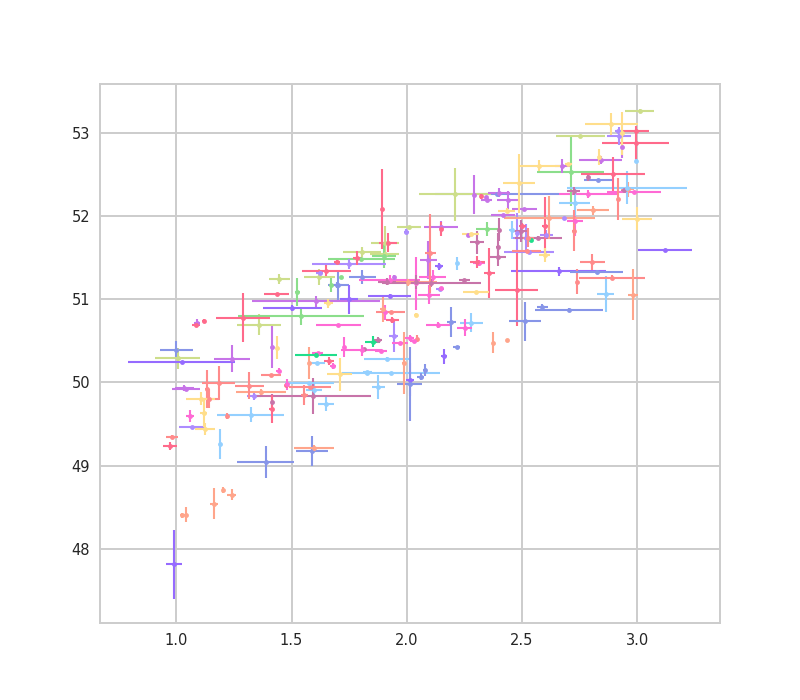

In [2]:
dg = DataGenerator(N_grbs=25, norm_mu=51, norm_sigma=0.5, gamma_mu=1.5, gamma_sigma=0.2)
dg.generate_sample()
dg.plot()

dg.write_data()

In [3]:
data = pystan.read_rdump('sim.data.R')

# Read in data

In [4]:
model = stan_utility.compile_model(filename='line_fit.stan')

Using cached StanModel


In [5]:
inits = []

for i in range(4):
        
    g_mu = np.random.uniform(-0.1,0.1)
    g_sig = np.random.uniform(0.15,0.25)
    
    n_mu = np.random.uniform(-0.1,0.1)
    n_sig = np.random.uniform(0.45,0.55)
    
    g_sh = np.random.uniform(1.4,1.6)
    n_sh = np.random.uniform(50.5,51.5)
    
    gamma = np.random.uniform(1.4,1.6,len(data['gamma']))
    norm = np.random.uniform(50.5,51.5,len(data['norm']))
    
    ep = np.random.uniform(1.9,2.1,len(data['ep_obs']))
    l = np.random.uniform(50.5,51.5,len(data['lum_obs']))
    
    
    chain_init = dict(gamma_mu = g_mu,
                      gamma_sigma = g_sig,
                      norm_mu = n_mu,
                      norm_sigma = n_sig,
                      gamma_shift = g_sh,
                      norm_shift = n_sh,
                      gamma = gamma,
                      norm = norm,
                      Ep_latent = ep,
                      L_latent = l)
    
    inits.append(chain_init)

In [6]:
fit = model.sampling(data=data,
                     chains=4,
                     init=inits,
                     iter=2000,
                     thin=1,
                     seed=1244,
                     control=dict(adapt_delta=0.9, max_treedepth=15))

In [7]:
stan_utility.check_all_diagnostics(fit)

n_eff / iter looks reasonable for all parameters
Rhat for parameter Ep_latent[51] is nan!
Rhat for parameter Ep_latent[81] is nan!
Rhat for parameter Ep_latent[84] is nan!
Rhat for parameter Ep_latent[115] is nan!
Rhat for parameter Ep_latent[119] is nan!
Rhat for parameter Ep_latent[202] is nan!
Rhat for parameter Ep_latent[205] is nan!
Rhat for parameter Ep_latent[215] is nan!
Rhat for parameter L_latent[165] is nan!
Rhat for parameter L_latent[205] is nan!
Rhat for parameter gamma_true is nan!
  Rhat above 1.1 indicates that the chains very likely have not mixed
0.0 of 4000 iterations ended with a divergence (0.0%)
0 of 4000 iterations saturated the maximum tree depth of 10 (0%)
E-BFMI indicated no pathological behavior


<IPython.core.display.Javascript object>


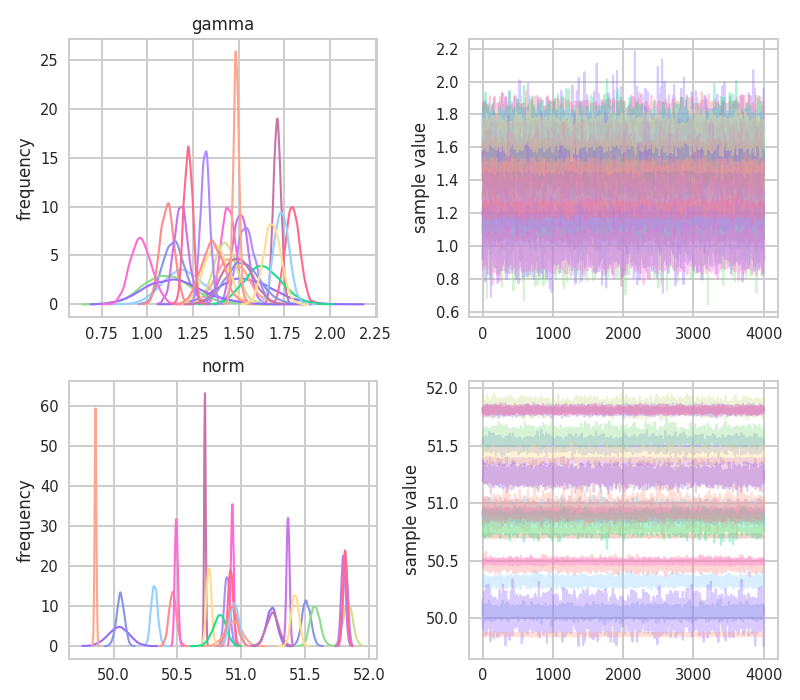

In [8]:
fit.plot(['gamma','norm']);

plt.tight_layout()

<IPython.core.display.Javascript object>


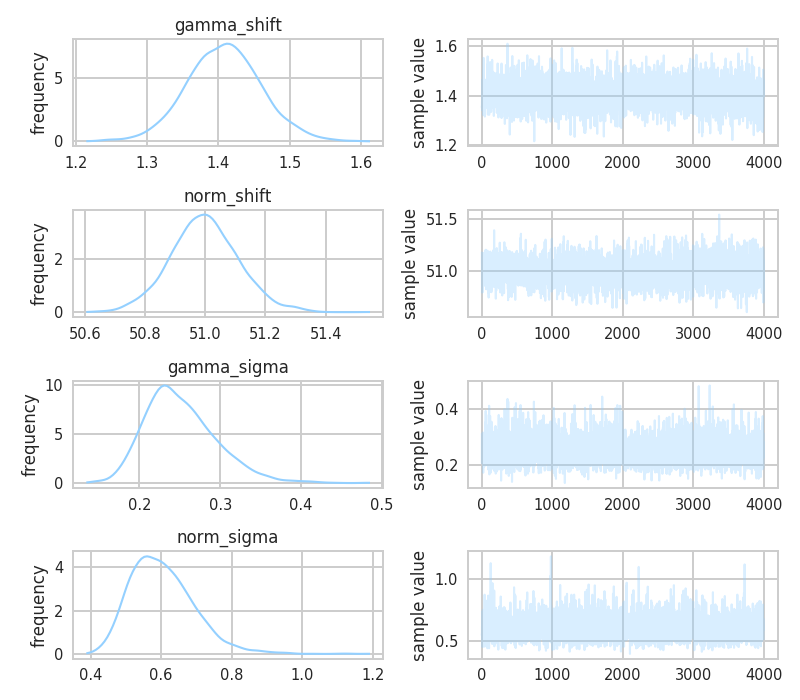

In [9]:
fit.plot(['gamma_shift', 'norm_shift', 'gamma_sigma' ,'norm_sigma' ]);

plt.tight_layout()

In [10]:
# simulation values:

# gamma_shift = 1.5, norm_shift = 51, gamma_sigma = 0.2, norm_sigma = 0.5

g_sh = fit.extract()['gamma_shift']
n_sh = fit.extract()['norm_shift']
g_sig = fit.extract()['gamma_sigma']
n_sig = fit.extract()['norm_sigma']

In [11]:
np.median(g_sh), np.median(n_sh), np.median(g_sig), np.median(n_sig)

(1.4084649813183003, 50.99644749325212, 0.2454133546396225, 0.5940764819394815)

In [12]:
fitted_lines = fit.extract()['fitted_lines']

<IPython.core.display.Javascript object>


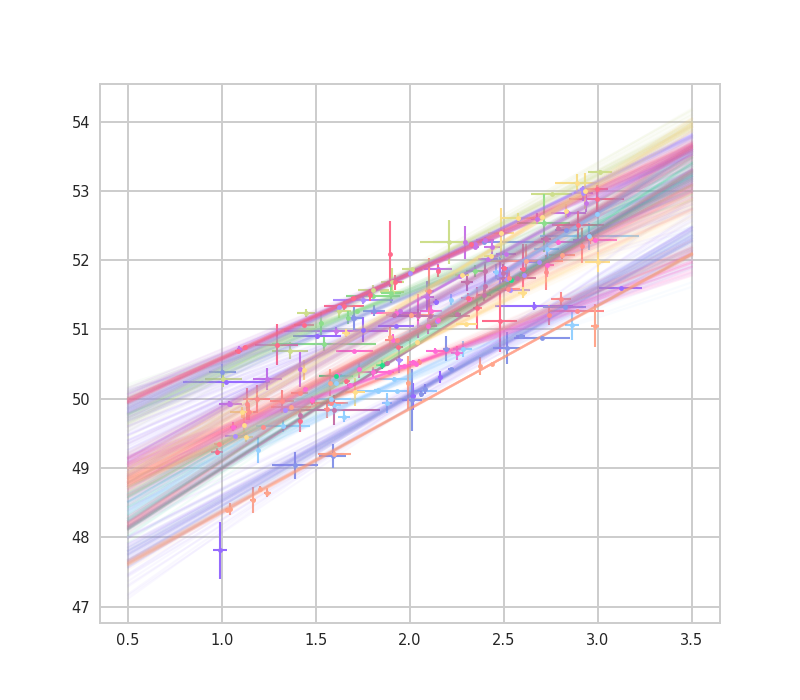

In [13]:
fig, ax = plt.subplots()

i=0
for n in range(data['N_grbs']):
    
    for y in fitted_lines[::100,n,:]:
        
        cc = (2*vapeplot.palette('vaporwave'))[n]
        
        
        ax.plot(data['ep_model'], y, alpha=0.05,color=cc)


    slice = np.arange(i,i+data['grb_length'][n])
    
    ax.errorbar(data['ep_obs'][slice], data['lum_obs'][slice],
                xerr=data['ep_err'][slice],
                yerr=data['lum_err'][slice],
                
                
                fmt='.',color=cc )

    i += data['grb_length'][n]
    #grb_size.append(idx.sum())

    
    
    

<IPython.core.display.Javascript object>


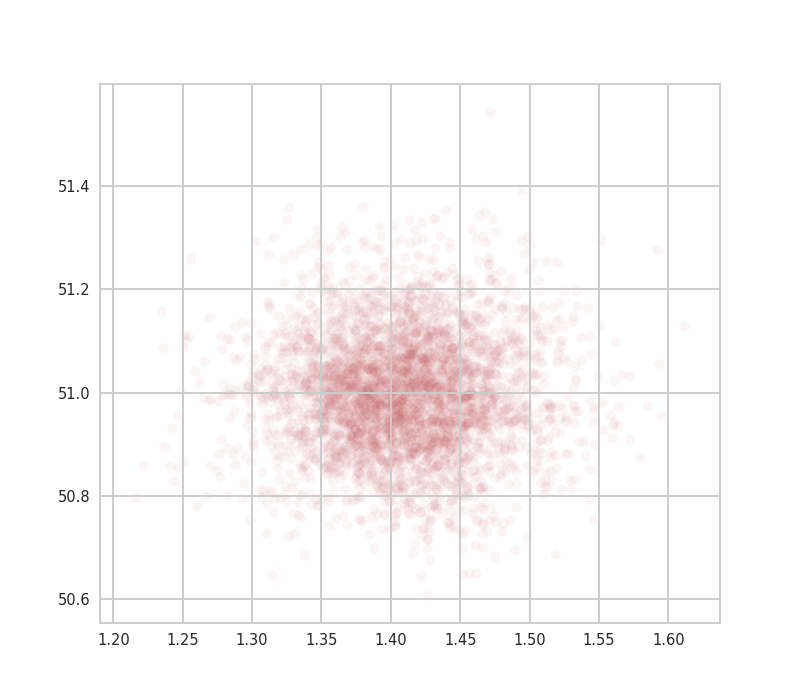

In [14]:
fig, ax = plt.subplots()

ax.scatter(fit.extract()['gamma_shift'], fit.extract()['norm_shift'],alpha=0.05, color='r')

<IPython.core.display.Javascript object>


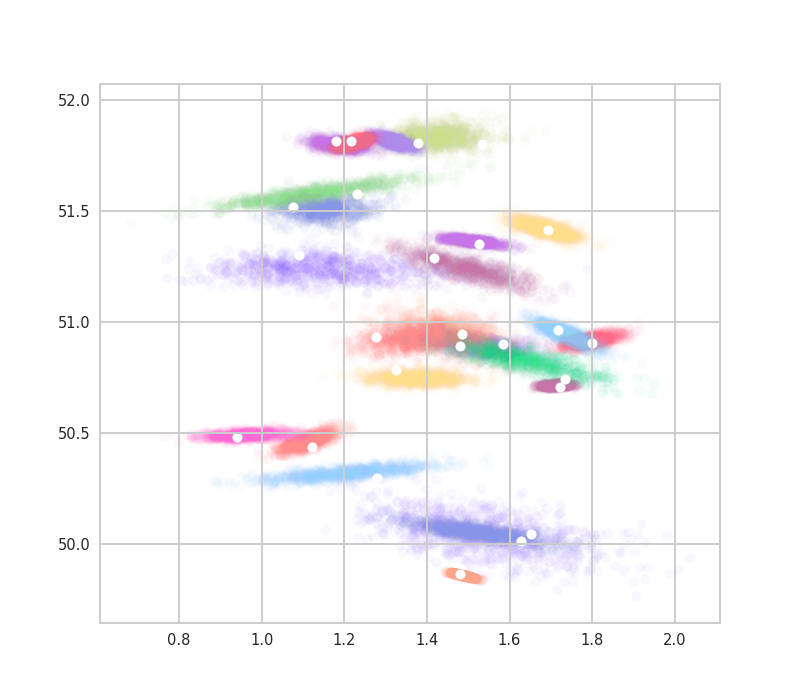

In [15]:
fig, ax = plt.subplots()

gammas= fit.extract()['gamma']
norms= fit.extract()['norm']

for n in range(data['N_grbs']):
    
    
        
        ax.scatter(gammas[::5,n], norms[::5,n], alpha=0.05,zorder = -1000)

        ax.scatter(data['gamma'][n], data['norm'][n], c='w',zorder=-10)

  

<IPython.core.display.Javascript object>


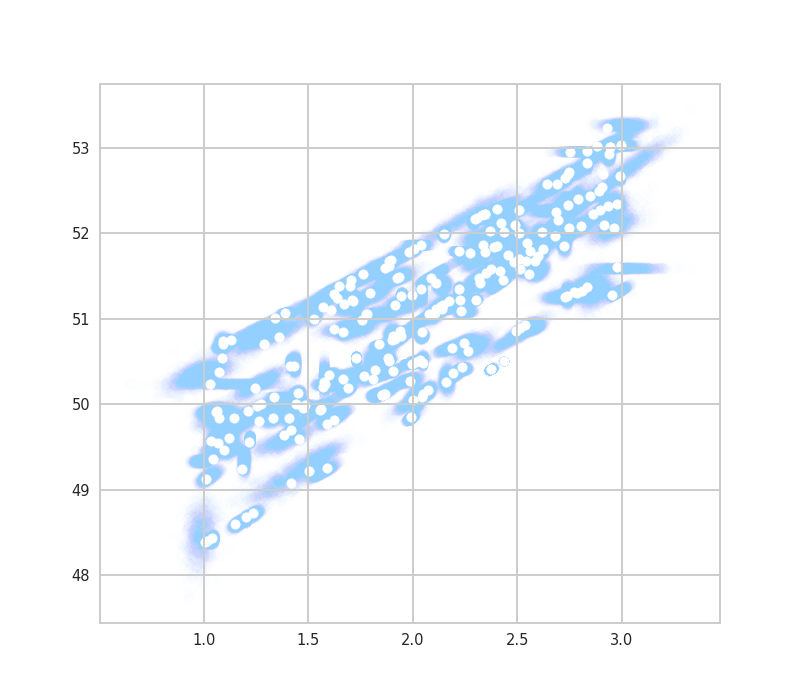

In [16]:
fig, ax = plt.subplots()

ep_latent = fit.extract()['Ep_latent']
lum_latent = fit.extract()['L_latent']

#for n in range(data['N_grbs']):
    
    
        
ax.scatter(ep_latent[::5,:], lum_latent[::5,:], alpha=0.01,zorder = -1000)

ax.scatter(dg._epeak,dg._luminosity,c='w')

        #ax.scatter(data['gamma'][n], data['norm'][n], c='w',zorder=-10)